## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

## 2. Read the dataset

In [3]:
purchase_history = pd.read_csv('dataset.csv')

In [4]:
purchase_history['timestamp'] = purchase_history['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f') + timedelta(hours=5, minutes=30))

## 3. Cohorting of users

In [282]:
## Depending upon the use case we can use any of the cohorting mechanisms
## For example: Lets say in a use case we have some campaign the success of which depends on the number of orders made rather than the value of the order. Habit formation. Exploration
## For example: For use cases like where we are concerned about the order value we can use the other approach. Exploitation

In [ ]:
# Segmentation is used to divide and understand current users 
# Cohort analysis is used to track and understand how users have changed or behaved over time

# Here in this notebook, I have performed cohorting to make the problem more interesting
# Segmentation can also be performed using same approaches, one would have to just consider all data insted of considering data over a week/month
# and adjust the class boudaries/thresholds accordingly.

### 3.1. Based on number of orders in a week

In [283]:
lower_limit = datetime.strptime('2022-08-16', '%Y-%m-%d')
upper_limit = lower_limit + timedelta(days=6)
print("Plot for data between: [{}, {}]".format(lower_limit.date(), upper_limit.date()))
n_order_week = purchase_history[(purchase_history.timestamp >= lower_limit) & (purchase_history.timestamp <= upper_limit)].groupby('user_id').agg({'purchase_value':['count']}).reset_index(col_level=1)

n_order_week.columns = ['userid', 'purchase_count']
n_order_week.rename_axis(axis=1)
n_order_week_agg = n_order_week.groupby('purchase_count').agg('count').reset_index()
n_order_week_agg.columns = ['purchase_count', 'n_users']
n_order_week_agg['per'] = n_order_week_agg['n_users']/sum(n_order_week_agg['n_users'])*100
n_order_week_agg['cum_per'] = n_order_week_agg['per'].cumsum()
# # n_order_week[n_order_week['order_count']<=n_order_week['order_count'].quantile(.99)].hist(bins=10, figsize=(20, 6), xrot=90);
n_order_week_agg

Plot for data between: [2022-08-16, 2022-08-22]


,purchase_count,n_users,per,cum_per
0,1,3299,65.482334,65.482334
1,2,1060,21.040095,86.522430
2,3,386,7.661771,94.184200
3,4,144,2.858277,97.042477
4,5,86,1.707027,98.749504
5,6,33,0.655022,99.404526
6,7,15,0.297737,99.702263
7,8,7,0.138944,99.841207
8,9,5,0.099246,99.940453
9,10,2,0.039698,99.980151


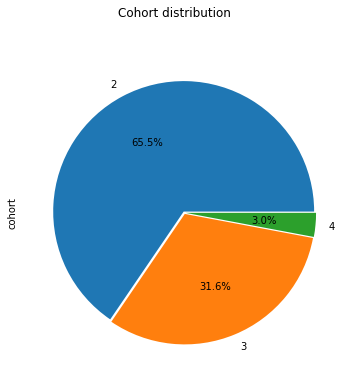

In [284]:
n_order_week['cohort'] = 1
n_order_week.loc[(n_order_week['purchase_count']>=1) &(n_order_week['purchase_count']<=1), 'cohort'] = 2
n_order_week.loc[(n_order_week['purchase_count']>=2) &(n_order_week['purchase_count']<=4), 'cohort'] = 3
n_order_week.loc[(n_order_week['purchase_count']>4), 'cohort'] = 4

n_order_week['cohort'].value_counts().plot.pie(subplots=True, figsize=(11, 6), title="Cohort distribution",
                                              autopct='%1.1f%%',explode=([0.01]*n_order_week['cohort'].nunique()),  startangle=0);

In [285]:
# Clearly from above we see that we can create a number of segments/cohorts for the user's based of their repeat history
# From visual inspection lets create 3 cohorts

# Cohort 1: order_count     x<1: New user (Cold user)
# Cohort 2: order_count 1>=x<=1: Low repeat users (Sparse user)
# Cohort 3: order_count 2=<x<=4: Medium repeat users (Dense user)
# Cohort 4: order_count    x>4 : High repeat users (Densest user)

# Note: From the data we observe that this distribution remains same over the weeks

In [286]:
# Let now find the distribution of users in these cohorts across non-overlapping months

upper_limit = datetime.strptime('2022-08-15', '%Y-%m-%d')
while(True):
    lower_limit = upper_limit +  timedelta(days=1)
    upper_limit = lower_limit + timedelta(days=6)
    df3 = purchase_history[(purchase_history.timestamp >= lower_limit) & (purchase_history.timestamp <= upper_limit)].groupby('user_id').agg({'purchase_value':['count']}).reset_index(col_level=1)
    df3.columns = ['userid', 'order_count']
    df3.rename_axis(axis=1)
    if(df3.shape[0]==0):
        break
    print("For data between: [{}, {}]".format(str(lower_limit.date()), str(upper_limit.date())), end='\t')
    print("Cohort 2: {}({}%) | Cohort 3: {}({}%) | Cohort 4: {}({}%)".format(
    
        df3[df3.order_count<=1].shape[0], round(df3[df3.order_count<=1].shape[0]/df3.shape[0]*100, 1),
        df3[(df3.order_count>=2)&(df3.order_count<=4)].shape[0], round(df3[(df3.order_count>=2)&(df3.order_count<=4)].shape[0]/df3.shape[0]*100, 1),
        df3[df3.order_count>4].shape[0], round(df3[df3.order_count>4].shape[0]/df3.shape[0]*100, 1)
    ))
    

For data between: [2022-08-16, 2022-08-22]	Cohort 2: 3299(65.5%) | Cohort 3: 1590(31.6%) | Cohort 4: 149(3.0%)
For data between: [2022-08-23, 2022-08-29]	Cohort 2: 3456(65.4%) | Cohort 3: 1676(31.7%) | Cohort 4: 151(2.9%)
For data between: [2022-08-30, 2022-09-05]	Cohort 2: 3376(66.9%) | Cohort 3: 1564(31.0%) | Cohort 4: 107(2.1%)
For data between: [2022-09-06, 2022-09-12]	Cohort 2: 3571(65.2%) | Cohort 3: 1762(32.2%) | Cohort 4: 147(2.7%)
For data between: [2022-09-13, 2022-09-19]	Cohort 2: 3571(64.6%) | Cohort 3: 1794(32.5%) | Cohort 4: 160(2.9%)
For data between: [2022-09-20, 2022-09-26]	Cohort 2: 3431(63.2%) | Cohort 3: 1839(33.9%) | Cohort 4: 155(2.9%)
For data between: [2022-09-27, 2022-10-03]	Cohort 2: 3567(63.8%) | Cohort 3: 1867(33.4%) | Cohort 4: 153(2.7%)
For data between: [2022-10-04, 2022-10-10]	Cohort 2: 3529(62.6%) | Cohort 3: 1898(33.7%) | Cohort 4: 210(3.7%)
For data between: [2022-10-11, 2022-10-17]	Cohort 2: 3676(62.0%) | Cohort 3: 2029(34.2%) | Cohort 4: 225(3.8%)
F

In [287]:
# Note: If we plot the same graph for other weeks as well we see a similar distribution. Therefore, we can say that the trend remains the same across weeeks
# On the face of it, this looks like a good approach but there is one caveat in this, we have not investigated that how many users come repeatedly every week.
# This is important because, if only small number of users make repeat order week on week, then there will be a lot of movement of users in different cohorts.
# When there is a lot of moment of users among the cohorts then, it would be difficult to design models that run specifically on some cohorts and it would become,
# furthore difficult to track the performance of those models.


# To tackle this issue, we can increase our window on one week and see what percetnage of users make orders atleast once in the new window period.

In [288]:
# Number of users making atleast one purchase in 1 week

week_wise_distinct_users = purchase_history[['user_id', 'timestamp']].copy(deep=True)
week_wise_distinct_users['week'] = purchase_history['timestamp'].apply(lambda x: str(x.date().isocalendar().week))
week_wise_distinct_users = week_wise_distinct_users.groupby('user_id').agg({'week': lambda x: len(set(x))}).reset_index()
week_wise_distinct_users.head(3)

,user_id,week
0,0000602f168960c53835096f2daad506a80fcef2b4b13a...,1
1,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,1
2,000700164cee77c05439c206a588b66fe734150ede585f...,12


In [289]:
total_weeks = week_wise_distinct_users['week'].nunique()
print(f"Number of weeks in the dataset: {total_weeks}")

Number of weeks in the dataset: 18


In [290]:
# Since that data for the first week (in August) and last week (in December) is incomplete. We roughly consider that there are 16 weeks

In [291]:
# Now we see that what percentage of users made atleast one purchase every week
print("Percenage of users, who made atleast one purchse in 1 week: {}%".format(round(week_wise_distinct_users[week_wise_distinct_users['week']>16].shape[0]/purchase_history['user_id'].nunique()*100, 2)))

Percenage of users, who made atleast one purchse in 1 week: 2.09%


### 3.2. Based on number of orders in a month

In [292]:
# We see that this is a very small number, therefore we need to incease the window from 1 week to a month
# We can also, investigate the window period of 2 weeks but that still would be a small number

In [294]:
lower_limit = datetime.strptime('2022-08-16', '%Y-%m-%d')
upper_limit = lower_limit + timedelta(days=30)

print("Plot for data between: [{}, {}]".format(lower_limit.date(), upper_limit.date()))
n_order_month = purchase_history[(purchase_history.timestamp >= lower_limit) & (purchase_history.timestamp <= upper_limit)].groupby('user_id').agg({'purchase_value':['count']}).reset_index(col_level=1)

n_order_month.columns = ['userid', 'purchase_count']
n_order_month.rename_axis(axis=1)
n_order_month_agg = n_order_month.groupby('purchase_count').agg('count').reset_index()
n_order_month_agg.columns = ['purchase_count', 'n_users']

n_order_month_agg['per'] = n_order_month_agg['n_users']/sum(n_order_month_agg['n_users'])*100
n_order_month_agg['cum_per'] = n_order_month_agg['per'].cumsum()
# n_order_month_agg

Plot for data between: [2022-08-16, 2022-09-15]


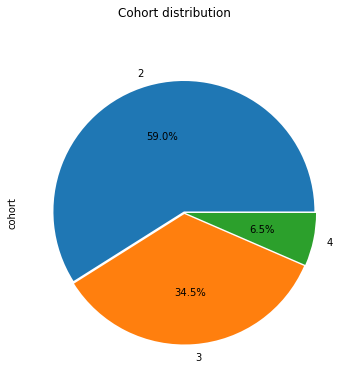

In [295]:
n_order_month['cohort'] = 1
n_order_month.loc[(n_order_month['purchase_count']>=1) &(n_order_month['purchase_count']<=2), 'cohort'] = 2
n_order_month.loc[(n_order_month['purchase_count']>=3) &(n_order_month['purchase_count']<=9), 'cohort'] = 3
n_order_month.loc[(n_order_month['purchase_count']>=10), 'cohort'] = 4

n_order_month['cohort'].value_counts().plot.pie(subplots=True, figsize=(11, 6), title="Cohort distribution",
                                              autopct='%1.1f%%', explode=([0.01]*n_order_month['cohort'].nunique()), startangle=0);

In [ ]:
# Clearly from above we see that we can create a number of segments/cohorts for the user's based of their repeat history
# From visual inspection lets create 4 cohorts

# Cohort 1: order_count     x<1: New user (Cold user)
# Cohort 2: order_count 1>=x<=2: Low repeat users (Sparse user)
# Cohort 3: order_count 3=<x<=9: Medium repeat users (Dense user)
# Cohort 4: order_count     x>9: High repeat users (Densest user)

# Note: From the data we observe that this distrinution remains same over the months

In [296]:
# Let now find the distribution of users in these cohorts across non-overlapping months

upper_limit = datetime.strptime('2022-08-15', '%Y-%m-%d')
while(True):
    lower_limit = upper_limit +  timedelta(days=1)
    upper_limit = lower_limit + timedelta(days=30)
    df3 = purchase_history[(purchase_history.timestamp >= lower_limit) & (purchase_history.timestamp <= upper_limit)].groupby('user_id').agg({'purchase_value':['count']}).reset_index(col_level=1)
    df3.columns = ['userid', 'order_count']
    df3.rename_axis(axis=1)
    if(df3.shape[0]==0):
        break
    print("For data between: [{}, {}]".format(str(lower_limit.date()), str(upper_limit.date())), end='\t')
    print("Cohort 2: {}({}%) | Cohort 3: {}({}%) | Cohort 4: {}({}%)".format(
    
        df3[df3.order_count<=2].shape[0], round(df3[df3.order_count<=2].shape[0]/df3.shape[0]*100, 1),
        df3[(df3.order_count>=3)&(df3.order_count<=9)].shape[0], round(df3[(df3.order_count>=3)&(df3.order_count<=9)].shape[0]/df3.shape[0]*100, 1),
        df3[df3.order_count>9].shape[0], round(df3[df3.order_count>9].shape[0]/df3.shape[0]*100, 1)
    ))
    

For data between: [2022-08-16, 2022-09-15]	Cohort 2: 7248(59.0%) | Cohort 3: 4246(34.5%) | Cohort 4: 801(6.5%)
For data between: [2022-09-16, 2022-10-16]	Cohort 2: 7357(56.9%) | Cohort 3: 4611(35.6%) | Cohort 4: 973(7.5%)
For data between: [2022-10-17, 2022-11-16]	Cohort 2: 7952(57.1%) | Cohort 3: 4839(34.7%) | Cohort 4: 1136(8.2%)
For data between: [2022-11-17, 2022-12-17]	Cohort 2: 7192(53.1%) | Cohort 3: 5053(37.3%) | Cohort 4: 1289(9.5%)


In [297]:
# Note: The window of 1 month and 1 week both are fine, it depends on the use case which one to use
# Generally for most use cases, a window of 1 month will be fine, but for some use cases we might use a window of 1 week.

### 3.3. Cohorting users based on AOV

In [299]:
lower_limit = datetime.strptime('2022-08-16', '%Y-%m-%d')
upper_limit = lower_limit + timedelta(days=30)

print("Plot for data between: [{}, {}]".format(lower_limit.date(), upper_limit.date()))
aov_month = purchase_history[(purchase_history.timestamp >= lower_limit) & (purchase_history.timestamp <= upper_limit)].groupby('user_id').agg({'purchase_value':['mean']}).reset_index(col_level=1)

aov_month.columns = ['userid', 'aov']
aov_month.rename_axis(axis=1)

aov_month['aov'].describe().to_frame()

Plot for data between: [2022-08-16, 2022-09-15]


,aov
count,12295.000000
mean,334.623278
std,219.198597
min,25.000000
25%,195.000000
50%,288.142857
75%,412.000000
max,3012.500000


In [300]:
# For the purposes of visualization, from the distribution of aov, if we remove a few extreme values then we get
aov_month_filtered = aov_month[aov_month['aov']<= aov_month['aov'].quantile(0.99)]
print("Percentage of users covered in filtered data of users: {}%".format(round(aov_month_filtered.shape[0]/aov_month.shape[0]*100, 3)))

Percentage of users covered in filtered data of users: 99.0%


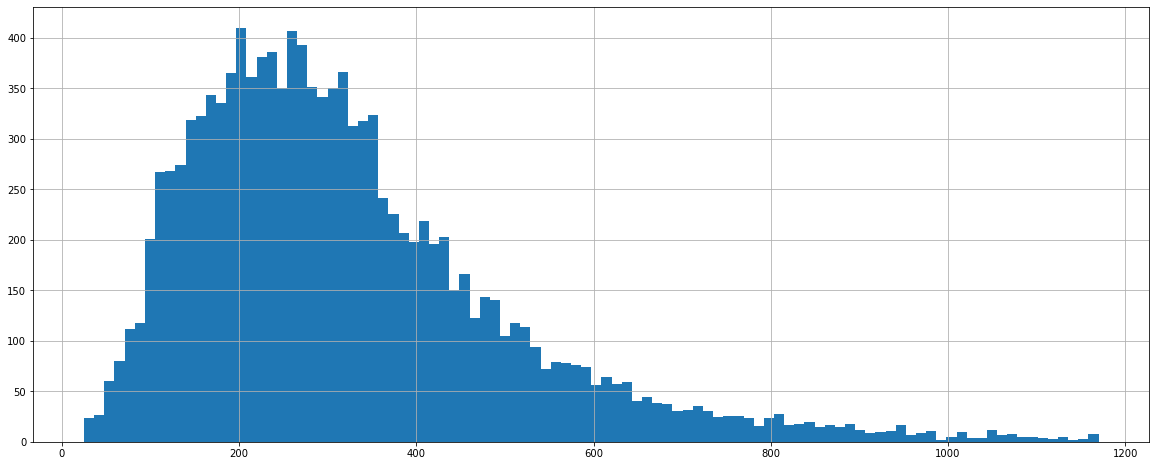

In [301]:
aov_month_filtered['aov'].hist(bins=100, figsize=(20,8));

In [302]:
# Now, depending upon the use case we can either classify users into 3, 4 or more cohorts
# Lets for the purposes of an example wedecide to segment users in 4 cohorts

# The heuristic that we are using here to cohort users is the quantile stats of the aov
# We can have cohorts based on following definition

# Cohort 1: aov                   x==0               : New user
# Cohort 2: aov                   x<  25th percentile: Low aov/gmv user
# Cohort 3: aov 25th percentile  >x<= 75th percentile: Medium aov/gmv user
# Cohort 4: aov 75th percentile  >x<= 90th percentile: High aov/gmv user
# Cohort 5: aov 75th percentile  >x                  : Very high aov/gmv user

# Note: we can adjust the cohort boundaries to adjust the number of users falling in each cohort according to the use case

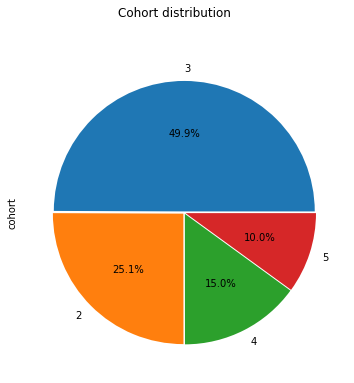

In [303]:
aov_month['cohort'] = 1
aov_month.loc[(aov_month['aov']<= aov_month['aov'].quantile(0.25)), 'cohort'] = 2
aov_month.loc[(aov_month['aov'] > aov_month['aov'].quantile(0.25))&(aov_month['aov']<= aov_month['aov'].quantile(0.75)), 'cohort'] = 3
aov_month.loc[(aov_month['aov'] > aov_month['aov'].quantile(0.75))&(aov_month['aov']<= aov_month['aov'].quantile(0.90)), 'cohort'] = 4
aov_month.loc[aov_month['aov'] > aov_month['aov'].quantile(0.90), 'cohort'] = 5

aov_month['cohort'].value_counts().plot.pie(subplots=True, figsize=(11, 6), title="Cohort distribution",
                                              autopct='%1.1f%%',explode=([0.01]*aov_month['cohort'].nunique()),  startangle=0);

In [309]:
# Let now find the distribution of users in these cohorts across non-overlapping months

upper_limit = datetime.strptime('2022-08-15', '%Y-%m-%d')
while(True):
    lower_limit = upper_limit +  timedelta(days=1)
    upper_limit = lower_limit + timedelta(days=30)
    df3 = purchase_history[(purchase_history.timestamp >= lower_limit) & (purchase_history.timestamp <= upper_limit)].groupby('user_id').agg({'purchase_value':['mean']}).reset_index(col_level=1)
    df3.columns = ['userid', 'aov']
    df3.rename_axis(axis=1)
    if(df3.shape[0]==0):
        break
    print("For data between: [{}, {}]".format(str(lower_limit.date()), str(upper_limit.date())), end='\t')
    print("Cohort 2: {}({}%) | Cohort 3: {}({}%) | Cohort 4: {}({}%  | Cohort 5: {}({}%)".format(
    
        df3[df3['aov']<= df3['aov'].quantile(0.25)].shape[0], round(df3[df3['aov']<= df3['aov'].quantile(0.25)].shape[0]/df3.shape[0]*100, 1),
        df3[(df3['aov'] > df3['aov'].quantile(0.25))&(df3['aov']<= df3['aov'].quantile(0.75))].shape[0], round(df3[(df3['aov'] > df3['aov'].quantile(0.25))&(df3['aov']<= df3['aov'].quantile(0.75))].shape[0]/df3.shape[0]*100, 1),
        df3[(df3['aov'] > df3['aov'].quantile(0.75))&(df3['aov']<= df3['aov'].quantile(0.90))].shape[0], round(df3[(df3['aov'] > df3['aov'].quantile(0.75))&(df3['aov']<= df3['aov'].quantile(0.90))].shape[0]/df3.shape[0]*100, 1),
        df3[df3['aov']> df3['aov'].quantile(0.90)].shape[0], round(df3[df3['aov']> df3['aov'].quantile(0.90)].shape[0]/df3.shape[0]*100, 1),
    ))

For data between: [2022-08-16, 2022-09-15]	Cohort 2: 3083(25.1%) | Cohort 3: 6140(49.9%) | Cohort 4: 1842(15.0%  | Cohort 5: 1230(10.0%)
For data between: [2022-09-16, 2022-10-16]	Cohort 2: 3249(25.1%) | Cohort 3: 6464(49.9%) | Cohort 4: 1934(14.9%  | Cohort 5: 1294(10.0%)
For data between: [2022-10-17, 2022-11-16]	Cohort 2: 3485(25.0%) | Cohort 3: 6967(50.0%) | Cohort 4: 2082(14.9%  | Cohort 5: 1393(10.0%)
For data between: [2022-11-17, 2022-12-17]	Cohort 2: 3390(25.0%) | Cohort 3: 6761(50.0%) | Cohort 4: 2029(15.0%  | Cohort 5: 1354(10.0%)


In [ ]:
# This was expected since this cohorting logic is based on qunatiles therefore the %age of users in each cohort will remain constant over months

### 3.4. Cohorting users based on RFM

###### - Another possible way is to group users based on the recency of their last purchase, often called RFM( Recency, Frequency, Monetary) analysis. This can help identify which users are most likely to make a purchase in the near future, and allow you to target your marketing efforts to those users.

In [328]:
# Calculating cohorts based on RFM parameters using a month data

lower_limit = datetime.strptime('2022-08-16', '%Y-%m-%d')
upper_limit = lower_limit + timedelta(days=30)

print("Plot for data between: [{}, {}]".format(lower_limit.date(), upper_limit.date()))
month_purchase_history = purchase_history[(purchase_history.timestamp >= lower_limit) & (purchase_history.timestamp <= upper_limit)].reset_index()

max_date = month_purchase_history["timestamp"].max()

# calculate the recency in days
month_purchase_history["recency"] = (max_date - month_purchase_history["timestamp"]).dt.days

# Group the data by user
user_groups = month_purchase_history.groupby("user_id")

# Create a new DataFrame to hold the segmentation data
segmentation = pd.DataFrame()

# Add a column for the recency
segmentation["recency"] = user_groups["recency"].min()

# Add a column for the frequency
segmentation["frequency"] = user_groups["purchase_value"].count()

# Add a column for the monetary
segmentation["monetary"] = user_groups["purchase_value"].sum()

# Set the index of the DataFrame to be the user IDs
segmentation.reset_index(level=0, inplace=True)

Plot for data between: [2022-08-16, 2022-09-15]


In [377]:
# Define the quartile ranges for recency, frequency and monetary
r_quartile = pd.qcut(segmentation["recency"], q=4, labels=["Most Recent", "Recent", "Mid-Recent","Least Recent"])
f_quartile = pd.qcut(segmentation["frequency"], q=4, labels=["Highly frequent", "Mid-Frequent", "Rare"], duplicates='drop')
m_quartile = pd.qcut(segmentation["monetary"], q=4, labels=["Highly Valuable", "Valuable", "Mid-Valuable","Not Valuable"])

# Add the quartile labels to the DataFrame
segmentation["r_quartile"] = r_quartile
segmentation["f_quartile"] = f_quartile
segmentation["m_quartile"] = m_quartile

In [378]:
segmentation.head(3)

,user_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,0,1,113.0,Most Recent,Highly frequent,Highly Valuable
1,000700164cee77c05439c206a588b66fe734150ede585f...,1,3,561.0,Most Recent,Mid-Frequent,Valuable
2,001481e9e6ea150295c6e7664c9eb824dc2393ede3a88d...,5,1,327.0,Recent,Highly frequent,Valuable


In [ ]:
# For the purposes of this assignment, I am just writing the further steps in this approach in words rather than writing the code as the actual implimentation 
# will depend on the use case. In this approach we can assign a number with each of the element in classes of recency, frequency, monetary. Then, we can 
# assign the weights to the classes itself based on heuritic depending upon the use case.

# Now, we come up with an overall score for the user which will be a weighted sum of class_weight*element_value
# Once we get this overall score then we can create different cohorts based on this score.

# Example:
# Lets assume we assign equal weights to each of the classes (recency, frequency, monetary) of [1, 1, 1]
# Also, for simplicity we lets assume we assign the elements of these classes similar number 
# Most Recent -> 4, Recent -> 3, Mid-Recent -> 2, Least Recent -> 1
# Highly frequent-> 3, Mid-Frequent -> 2, Rare -> 1
# and so on...

# Now to get the overall score for lets say user_id == '0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b69ac0379e0de0d8dd7' (say u1)
# overall_score for u1 = 1*4 + 1*3 + 1*4 = 11

# Similarly we can get the score for all uses and then we can get the distribution of these scores.
# Based on the distribution and the use case, we can define different cohorts based on quantiles or binning logic

# Important note: We actual class weights will arrive from some heuristic or some business logic and is taken [1, 1, 1] in the example just for explanation

## 4. User segmentation

In [478]:
total_order_per_user = purchase_history['user_id'].value_counts().reset_index()
total_order_per_user.columns = ['user_id', 'n_orders']

In [475]:
quantile_wise_order_df = total_order_per_user['n_orders'].quantile([i/10 for i in range(1, 11)])
quantile_wise_order_df = quantile_wise_order_df.reset_index()
quantile_wise_order_df.columns = ['quantile', 'n_orders']
quantile_wise_order_df

,quantile,n_orders
0,0.1,1.0
1,0.2,1.0
2,0.3,2.0
3,0.4,2.0
4,0.5,4.0
5,0.6,5.0
6,0.7,8.0
7,0.8,12.0
8,0.9,22.0
9,1.0,301.0


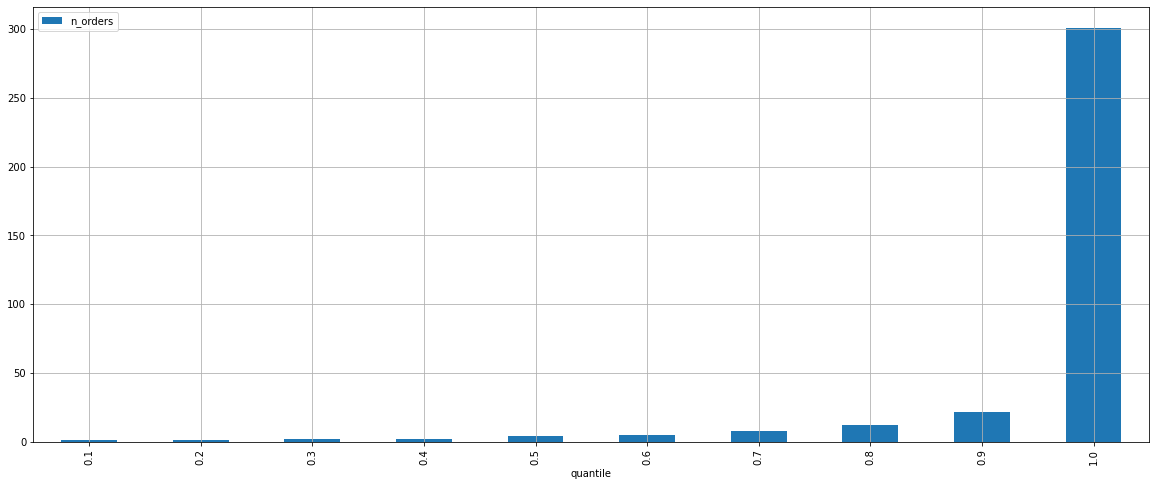

In [477]:
quantile_wise_order_df.plot.bar(x='quantile', y='n_orders', figsize=(20,8), grid=True);

In [ ]:
purchase_history

aov_month_filtered = aov_month[aov_month['aov']<= aov_month['aov'].quantile(0.99)]
